In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import keras
import random
import numpy as np 
import pandas as pd
import glob
import cv2
import os
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential
import skimage.io
import os
import tensorflow as tf
from keras import layers
from keras import Model
from os import getcwd
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D
from keras.layers import MaxPooling2D, Dropout,Flatten
from keras import backend as K
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.xception import preprocess_input
from keras.layers import Input, Conv2D, Dense, concatenate
from keras.models import Model


In [4]:
data_dir = Path('/content/COVID Splitaug2') 
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')
val_dir = os.path.join(data_dir, 'Val')

train_covid_dir = os.path.join(train_dir, 'COVID') 
train_noncovid_dir = os.path.join(train_dir, 'NON-COVID')
validation_covid_dir = os.path.join(val_dir, 'COVID')
validation_noncovid_dir = os.path.join(val_dir, 'NON-COVID')
test_covid_dir = os.path.join(test_dir, 'COVID') 
test_noncovid_dir = os.path.join(test_dir, 'NON-COVID')


train_covid_fnames = os.listdir(train_covid_dir)
train_noncovid_fnames = os.listdir(train_noncovid_dir)
validation_covid_fnames = os.listdir(validation_covid_dir)
validation_noncovid_fnames = os.listdir(validation_noncovid_dir)
test_covid_fnames = os.listdir(test_covid_dir)
test_noncovid_fnames = os.listdir(test_noncovid_dir)

print(len(train_covid_fnames))
print(len(validation_covid_fnames))
print(len(train_noncovid_fnames))
print(len(validation_noncovid_fnames))
print("Test Covid", len(test_covid_fnames))
print("Test Noncovid", len(test_noncovid_fnames))


955
60
1170
58
Test Covid 98
Test Noncovid 105


In [29]:
train_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224, 224)
                                                    )
validation_datagen = ImageDataGenerator(rescale=1./255)
 

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(224, 224))

Found 2125 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


In [30]:
def mini_block(filters, x):
  conv = tf.keras.layers.Conv2D(filters , kernel_size=(3, 3),padding='same')(x)
  bn = tf.keras.layers.BatchNormalization()(conv)
  act = tf.keras.layers.Activation('relu')(bn)
  return act

def double_mini_block(filters, x):
  conv = tf.keras.layers.Conv2D(filters , kernel_size=(3, 3),padding='same')(x)
  bn = tf.keras.layers.BatchNormalization()(conv)
  act = tf.keras.layers.Activation('relu')(bn)
  conv = tf.keras.layers.Conv2D(filters , kernel_size=(3, 3),padding='same')(act)
  bn = tf.keras.layers.BatchNormalization()(conv)
  act = tf.keras.layers.Activation('relu')(bn)
  return act


def MFL_block(f,inp):
  block1 = mini_block(f,inp)
  block2 = double_mini_block(f,inp)
  #concat
  c1 =  concatenate([block1, block2])
  #1x1 conv for parameter reduction
  conv = tf.keras.layers.Conv2D(f , kernel_size=(1, 1))(c1)
  block3 = mini_block(f,conv)
  #3x3 block from input
  block4 = mini_block(f,inp)
  c2 = concatenate([block3, block4])
  conv = tf.keras.layers.Conv2D(f , kernel_size=(1, 1))(c2)
  return conv

def MFL_Net():
  inp = tf.keras.layers.Input(shape=(224,224,3))
  b1 = mini_block(16,inp)
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(b1)
  p1 = MFL_block(16,pool)
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p1)
  p2 = MFL_block(32,pool)
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p2)
  p3 = MFL_block(64,pool)
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p3)
  p4 = MFL_block(128,pool)
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p4)
  globavg = tf.keras.layers.GlobalAveragePooling2D()(pool)
  drop = tf.keras.layers.Dropout(rate=0.5)(globavg)
  out = tf.keras.layers.Dense(2, activation='softmax')(drop)
  model = tf.keras.Model(inputs=inp, outputs=out)
  model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])
  return model

model = MFL_Net()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 224, 224, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 224, 224, 16) 64          conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 224, 224, 16) 0           batch_normalization_42[0][0]     
____________________________________________________________________________________________

In [31]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.000001)
callbacks = [tf.keras.callbacks.ModelCheckpoint('MFL_Net.hdf5', save_weights_only=True, save_best_only=True,
            mode='min'),tf.keras.callbacks.ReduceLROnPlateau( monitor = 'val_loss',factor=0.5, patience=4, min_lr=0.000000001)] 
history = model.fit_generator(train_generator,
            validation_data = validation_generator,
            epochs =150, verbose=1, callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
67/67 [==============================] - 14s 163ms/step - loss: 0.7587 - acc: 0.6211 - val_loss: 0.7681 - val_acc: 0.4915
Epoch 2/150
67/67 [==============================] - 10s 154ms/step - loss: 0.5022 - acc: 0.7882 - val_loss: 0.9134 - val_acc: 0.4915
Epoch 3/150
67/67 [==============================] - 10s 154ms/step - loss: 0.4219 - acc: 0.8179 - val_loss: 2.0558 - val_acc: 0.4915
Epoch 4/150
67/67 [==============================] - 10s 152ms/step - loss: 0.3463 - acc: 0.8585 - val_loss: 4.1038 - val_acc: 0.4915
Epoch 5/150
67/67 [==============================] - 10s 154ms/step - loss: 0.2564 - acc: 0.9052 - val_loss: 3.0060 - val_acc: 0.5085
Epoch 6/150
67/67 [==============================] - 10s 153ms/step - loss: 0.2150 - acc: 0.9159 - val_loss: 1.3541 - val_acc: 0.5678
Epoch 7/150
67/67 [==============================] - 10s 153ms/step - loss: 0.1590 - acc: 0.9390 - val_loss: 0.6410 - val_acc: 0.7203
Epoch 8/150
67/67 [==============================] - 10s 153ms

In [9]:
data_dir = Path('/content/COVID Splitaug2')
test_dir = os.path.join(data_dir, 'Test')
test_malaria_dir = os.path.join(test_dir, 'COVID') #Replace the folder names
test_uninfected_dir = os.path.join(test_dir, 'NON-COVID')
test_malaria_fnames = os.listdir(test_malaria_dir)
test_uninfected_fnames = os.listdir(test_uninfected_dir)
print(len(test_malaria_fnames))
print(len(test_uninfected_fnames))

98
105


In [10]:

testGenerator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dir, 
                                                                         batch_size=8,
                                                                         class_mode='categorical',
                                                                         shuffle=False,
                                                                         target_size=(224,224))

Found 203 images belonging to 2 classes.


In [32]:

import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
batch_size = 8
num_of_test_samples = 203
predictions = model.predict_generator(testGenerator)

y_pred = np.argmax(predictions, axis=1)

true_classes = testGenerator.classes

class_labels = list(testGenerator.class_indices.keys())   

print(class_labels)

print(confusion_matrix(testGenerator.classes, y_pred))

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


['COVID', 'NON-COVID']
[[ 87  11]
 [  2 103]]
              precision    recall  f1-score   support

       COVID       0.98      0.89      0.93        98
   NON-COVID       0.90      0.98      0.94       105

    accuracy                           0.94       203
   macro avg       0.94      0.93      0.94       203
weighted avg       0.94      0.94      0.94       203



In [33]:
from sklearn.metrics import  f1_score,roc_auc_score, accuracy_score
f1_score(testGenerator.classes, y_pred)

0.9406392694063928

In [34]:
accuracy_score(testGenerator.classes, y_pred)

0.9359605911330049

In [35]:
roc_auc_score(testGenerator.classes, y_pred)

0.9343537414965987

In [25]:
%config InlineBackend.figure_format = 'svg'

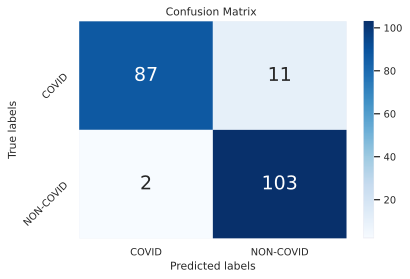

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
cm = confusion_matrix(testGenerator.classes, y_pred)

names = ["COVID", "NON-COVID"]

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

labels = [f"{v1}" for v1 in group_counts]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=0.9)
sns.heatmap(cm, annot=labels, fmt='', xticklabels= names, yticklabels= names, annot_kws={"size": 19}, cmap='Blues')
plt.yticks(rotation=45) 

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion Matrix ')
plt.savefig('cm93.59.svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()
from google.colab import files
files.download("cm93.59.svg")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

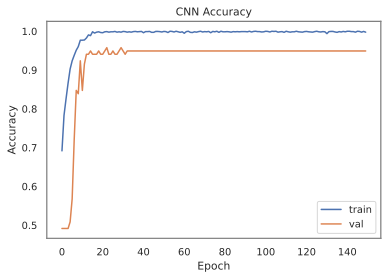

In [38]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best',facecolor="white")
plt.grid(b=None)

ax = plt.axes()
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')

ax.set_facecolor("white")

plt.savefig('acc93.59.svg',bbox_inches = 'tight', pad_inches = 0)


files.download("acc93.59.svg")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

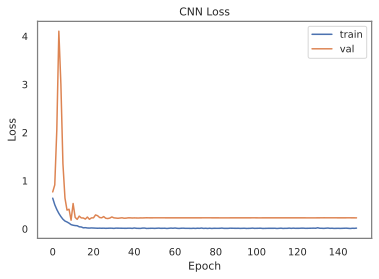

In [39]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best',facecolor="white")
plt.grid(b=None)
ax = plt.axes()
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
ax.patch.set_edgecolor('black')  

  
ax.set_facecolor("white")

plt.savefig("loss93.59.svg",bbox_inches = 'tight', pad_inches = 0)
files.download("loss93.59.svg")
plt.show()

In [40]:
tf.keras.models.save_model(model,'MFL_Net_93.59.hdf5')

In [125]:
files.download("MFL_Net_93.59.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>